## Toronto Crime Analysis

### This notebook analyzes crime trends over time from 2014 to 2017

In [1]:
%matplotlib notebook

In [2]:
import requests
import json
import pandas as pd
from matplotlib import pyplot as plt
from pprint import pprint
from pandas.io.json import json_normalize
from IPython.display import clear_output
from scipy import stats

In [38]:
# read crime data
crimes_df = pd.DataFrame(pd.read_csv('../output/crimes_csv.csv', index_col=0))
crimes_df.head()

,Hood_ID,Index_,MCI,Neighbourhood,event_unique_id,occurrencedate,occurrenceday,occurrencedayofweek,occurrencedayofyear,occurrencehour,occurrencemonth,occurrenceyear,offence,premisetype
0,84,976,Assault,Little Portugal (84),GO-2015942420,1388552400000,1,Wednesday,1,0,January,2014,Assault,Apartment
1,25,977,Assault,Glenfield-Jane Heights (25),GO-20162295518,1388552400000,1,Wednesday,1,0,January,2014,Assault,Apartment
2,71,978,Assault,Cabbagetown-South St.James Town (71),GO-20142458487,1388552400000,1,Wednesday,1,0,January,2014,Assault,Apartment
3,71,979,Assault,Cabbagetown-South St.James Town (71),GO-20142458487,1388552400000,1,Wednesday,1,0,January,2014,Assault,Apartment
4,58,980,Theft Over,Old East York (58),GO-20141573896,1388552400000,1,Wednesday,1,0,January,2014,Theft Over,House


In [39]:
# group by year and month
crimes_per_month = crimes_df.groupby(['occurrenceyear', 'occurrencemonth'])['event_unique_id'].count()
crimes_per_month_df = crimes_per_month.to_frame().reset_index()
crimes_per_month_df.head()

,occurrenceyear,occurrencemonth,event_unique_id
0,2014,April,2507
1,2014,August,2760
2,2014,December,2472
3,2014,February,2192
4,2014,January,2430


In [40]:
# make column for month plus year 
crimes_per_month_df['Month'] = crimes_per_month_df['occurrencemonth'] + " " + crimes_per_month_df['occurrenceyear'].map(str)

In [41]:
crimes_per_month_df.head()

,occurrenceyear,occurrencemonth,event_unique_id,Month
0,2014,April,2507,April 2014
1,2014,August,2760,August 2014
2,2014,December,2472,December 2014
3,2014,February,2192,February 2014
4,2014,January,2430,January 2014


In [42]:
# to sort by months, use catagories
Months = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]

In [43]:
crimes_per_month_df['occurrencemonth'] = pd.Categorical(crimes_per_month_df['occurrencemonth'], categories=Months, ordered=True)

In [44]:
# sort by year and month
crimes_per_month_df_sorted = crimes_per_month_df.sort_values(['occurrenceyear', 'occurrencemonth'])
crimes_per_month_df_sorted.head()

,occurrenceyear,occurrencemonth,event_unique_id,Month
4,2014,January,2430,January 2014
3,2014,February,2192,February 2014
7,2014,March,2418,March 2014
0,2014,April,2507,April 2014
8,2014,May,2854,May 2014


In [45]:
# extract counts and month names while sorted:
counts_per_month = crimes_per_month_df_sorted['event_unique_id']
month = crimes_per_month_df_sorted['Month']

<IPython.core.display.Javascript object>


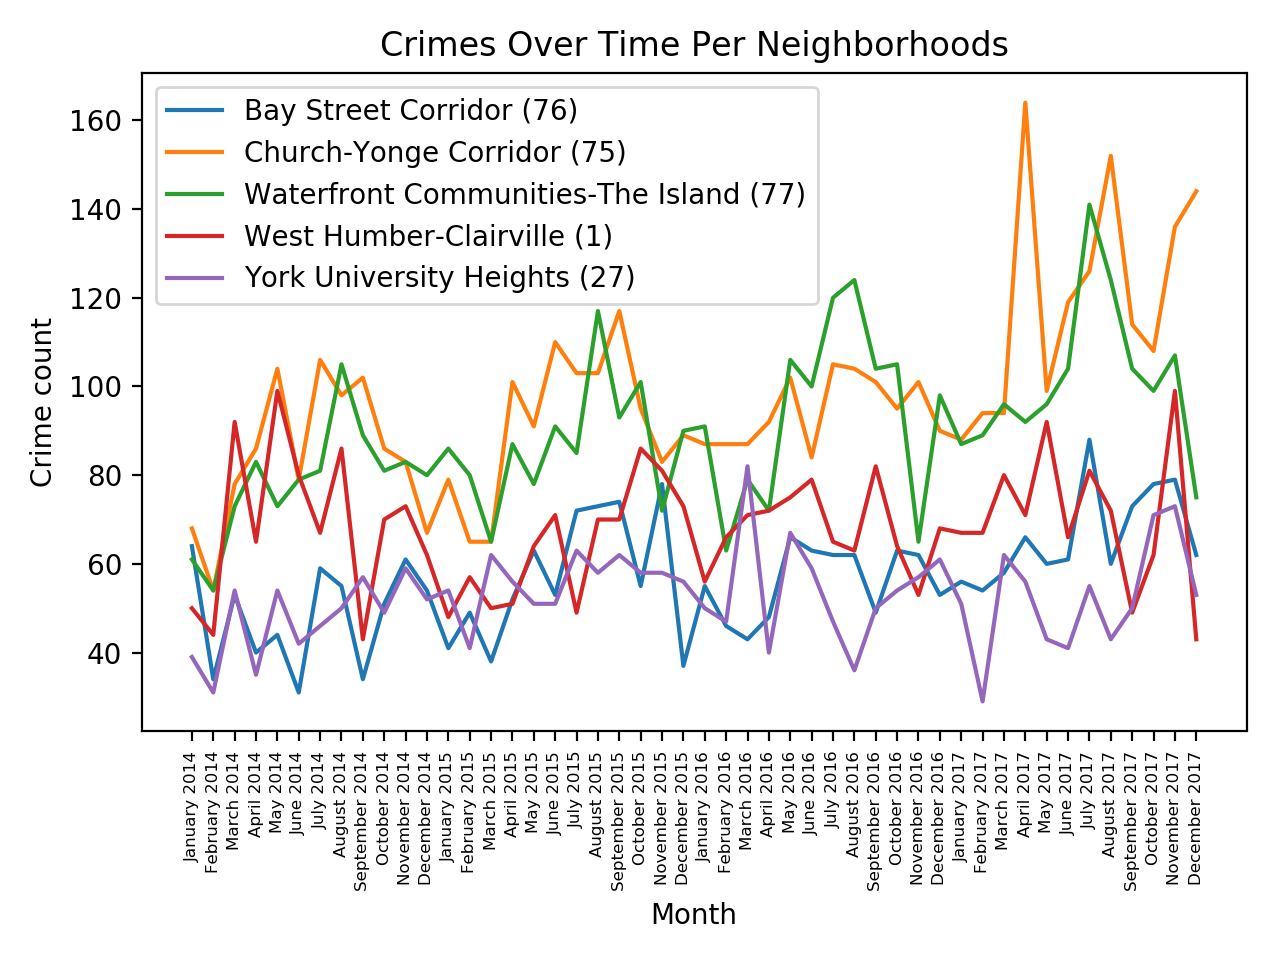

In [46]:
# get columns and rename
plt.plot(month, counts_per_month)
plt.xticks(rotation=90, fontsize=6)
plt.title('Crimes Over Time')
plt.ylabel('Crime count')
plt.xlabel('Month')
plt.tight_layout()
plt.savefig('../output/total_crimes_over_time')
plt.show()

### Crimes always dip significantly in Jan-Feb of each year
### Upward trend overall :(


In [47]:
# why do crimes dip this much in winter? maybe certain types of crime?

In [48]:
# group by year and month and type
crime_types_per_month = crimes_df.groupby(['occurrenceyear', 'occurrencemonth', 'MCI'])['event_unique_id'].count()
crime_types_per_month_df = crime_types_per_month.to_frame().unstack('MCI').reset_index()
crime_types_per_month_df.head()

occurrenceyear occurrencemonth event_unique_id                             \
MCI                                        Assault Auto Theft Break and Enter   
0             2014           April            1231        292             624   
1             2014          August            1472        334             630   
2             2014        December            1323        255             555   
3             2014        February            1153        227             470   
4             2014         January            1259        237             577   

                        
MCI Robbery Theft Over  
0       285         75  
1       240         84  
2       246         93  
3       276         66  
4       260         97

In [49]:
crime_types_per_month_df['Month'] = crime_types_per_month_df['occurrencemonth'] + " " + crime_types_per_month_df['occurrenceyear'].map(str)

In [50]:
# sort
crime_types_per_month_df['occurrencemonth'] = pd.Categorical(crime_types_per_month_df['occurrencemonth'], categories=Months, ordered=True)

In [51]:
crime_types_per_month_df_sorted = crime_types_per_month_df.sort_values(['occurrenceyear', 'occurrencemonth'])
crime_types_per_month_df_sorted.head()

occurrenceyear occurrencemonth event_unique_id                             \
MCI                                        Assault Auto Theft Break and Enter   
4             2014         January            1259        237             577   
3             2014        February            1153        227             470   
7             2014           March            1214        295             563   
0             2014           April            1231        292             624   
8             2014             May            1490        288             626   

                                Month  
MCI Robbery Theft Over                 
4       260         97   January 2014  
3       276         66  February 2014  
7       287         59     March 2014  
0       285         75     April 2014  
8       363         87       May 2014

In [52]:
# extract mcis
MCIs = list(crimes_df.groupby('MCI').groups)
MCIs

['Assault', 'Auto Theft', 'Break and Enter', 'Robbery', 'Theft Over']

In [53]:
counts_per_type = {}
months ={}
for MCI in MCIs:
    counts_per_type[MCI] = crime_types_per_month_df_sorted['event_unique_id'][MCI]
    months[MCI] = crime_types_per_month_df_sorted['Month']

In [54]:
plt.clf()
for MCI in MCIs:
    plt.plot(months[MCI], counts_per_type[MCI], label=MCI)

plt.xticks(rotation=90, fontsize=6)
plt.title('Crimes Per Type Over Time')
plt.ylabel('Crime count')
plt.xlabel('Month')
plt.tight_layout()
plt.legend()
plt.show()
plt.savefig('../output/crime_types_over_time')

### all types dip in jan/feb but assault more than other

### lets analyze crimes per neighborhood

In [55]:
# group by neighborhood first, thenyear and month
crimes_per_hood = crimes_df.groupby(['Neighbourhood', 'occurrenceyear', 'occurrencemonth'])['event_unique_id'].count()
crimes_per_hood_df = crimes_per_hood.to_frame().reset_index()
crimes_per_hood_df.head()

,Neighbourhood,occurrenceyear,occurrencemonth,event_unique_id
0,Agincourt North (129),2014,April,19
1,Agincourt North (129),2014,August,15
2,Agincourt North (129),2014,December,14
3,Agincourt North (129),2014,February,17
4,Agincourt North (129),2014,January,20


In [56]:
crimes_per_hood_df['Month'] = crimes_per_hood_df['occurrencemonth'] + " " + crimes_per_hood_df['occurrenceyear'].map(str)

In [57]:
crimes_per_hood_df['occurrencemonth'] = pd.Categorical(crimes_per_hood_df['occurrencemonth'], categories=Months, ordered=True)

In [58]:
# sort by neighborhood, then year and month
crimes_per_hood_df_sorted = crimes_per_hood_df.sort_values(['Neighbourhood','occurrenceyear', 'occurrencemonth'])
crimes_per_hood_df_sorted.head()

,Neighbourhood,occurrenceyear,occurrencemonth,event_unique_id,Month
4,Agincourt North (129),2014,January,20,January 2014
3,Agincourt North (129),2014,February,17,February 2014
7,Agincourt North (129),2014,March,12,March 2014
0,Agincourt North (129),2014,April,19,April 2014
8,Agincourt North (129),2014,May,6,May 2014


In [59]:
neighbourhoods = crimes_per_hood_df_sorted['Neighbourhood'].unique()
len(neighbourhoods)

140

In [60]:
# extract series for each neighbourhood:
counts={}
months={}
for neighbourhood in neighbourhoods:
    counts[neighbourhood] = crimes_per_hood_df_sorted['event_unique_id'][crimes_per_hood_df_sorted['Neighbourhood']==neighbourhood]
    months[neighbourhood] = crimes_per_hood_df_sorted['Month'][crimes_per_hood_df_sorted['Neighbourhood']==neighbourhood]

In [61]:
plt.clf()
for neighbourhood in neighbourhoods:
    plt.plot(months[neighbourhood], counts[neighbourhood], label=neighbourhood)

plt.xticks(rotation=90, fontsize=6)
plt.title('Crimes Over Time')
plt.ylabel('Crime count')
plt.xlabel('Month')
plt.tight_layout()
plt.legend()
plt.show()

In [62]:
# too many to see clearly
# lets get the neighborhoods that have the most significant change over time
changes={}
for neighbourhood in neighbourhoods:
    changes[neighbourhood] = ( counts[neighbourhood].max() - counts[neighbourhood].min() ) 

In [63]:
# sort the values of change
sorted_changes = sorted ( list(changes.values()), reverse=True)

In [64]:
# get top 10
high_changes = sorted_changes[:5]
high_changes

[110, 87, 57, 56, 53]

In [65]:
# get which neighborhoods
neighbourhoods_of_interest = [ neighbourhood for neighbourhood in neighbourhoods if changes[neighbourhood] in high_changes ]

In [66]:
# plot only these
plt.clf()
for neighbourhood in neighbourhoods_of_interest:
    plt.plot(months[neighbourhood], counts[neighbourhood], label=neighbourhood)

plt.xticks(rotation=90, fontsize=6)
plt.title('Crimes Over Time Per Neighborhoods')
plt.ylabel('Crime count')
plt.xlabel('Month')
plt.legend()
plt.tight_layout()
plt.savefig('../output/crimes_over_time_for_neighborhoods_with_largest_change')
plt.show()